# Explanation of Optical Wave Breaking

The Nonlinear Schrodinger Equation is given by:

$\frac{\partial A}{\partial z}=-i \frac{\beta_2}{2} \frac{\partial^2 A}{\partial T^2}+i\gamma|A|^2A$.

If $\beta_2<0$, meaning that we have anormalous dispersion where blue light propagates faster than red light, and $\gamma>0$, we can achieve "solitons"; optical pulses, which retain their shape as they propagate. 

But what happens if $\beta_2>0$ along with $\gamma>0$? 

Now the dispersion is "normal", causing red light moves faster than blue light. Furthermore, SPM will generate lots of red light in the front of the pulse and blue light in the back. Therefore, we might expect the push to spread out much quicker with a "rush" of red light in the front.

Link to excellent explanation: 
https://prefetch.eu/know/concept/optical-wave-breaking/

# Import libraries

In [1]:
import numpy as np
import matplotlib.pyplot as plt

## Import custom functions for running SSFM

In [2]:
from ssfm_functions import *


## Initialize timebase

In [3]:
N  = 2**12 #Number of points
dt = 0.1e-12 #Time resolution [s] 

timeFreq_test=timeFreq_class(N,dt)

 ### timeFreq Configuration Parameters ###
  Number of points = 4096
  Start time, tmin = -204.800ps
  Stop time, tmax = 204.800ps
  Time resolution, dt = 0.100ps
  
  Start frequency= -4.999THz
  Stop frequency = 4.996THz
  Frequency resolution= 2440.810MHz
   


## Initialize fiber with normal dispersion

In [4]:


#Define fiber parameters
Length          = 132.5      #Fiber length in m

gamma           = 400e-3     #Nonlinearity parameter in 1/W/m 
beta2           = 100e3    #Dispersion in fs^2/m (units typically used when referring to beta2) 
beta2          *= (1e-30)  #Convert fs^2 to s^2 so everything is in SI units
alpha_dB_per_m  = 0.0e-3   #Power attenuation coeff in decibel per m. Usual value at 1550nm is 0.2 dB/km

#Note:  beta2>0 is normal dispersion with red light pulling ahead, 
#       causing a negative leading chirp
#       
#       beta2<0 is anormalous dispersion with blue light pulling ahead, 
#       causing a positive leading chirp.


#  Initialize class
fiber=Fiber_class(Length, gamma, beta2, alpha_dB_per_m)

## Initialize Gaussian pulse

In [5]:
#Initialize Gaussian pulse


testAmplitude = np.sqrt(1)                    #Amplitude in units of sqrt(W)
testDuration  =100*timeFreq_test.time_step    #Pulse 1/e^2 duration [s]
testOffset    = 0                             #Time offset
testChirp = 0                                 #Chirp factor
testCarrierFreq=0                             #Freq. offset
testPulseType='gaussian'                      #'Gaussian', 'square', 'sech'
testOrder = 1                                 #Order of Gaussian pulse
testNoiseAmplitude = 0.0                      #Added ASE noise amplitude


testInputSignal = input_signal_class(timeFreq_test, 
                                     testAmplitude ,
                                     testDuration,
                                     testOffset,
                                     testChirp,
                                     testCarrierFreq,
                                     testPulseType,
                                     testOrder,
                                     testNoiseAmplitude)

## Choose step configuration

In [8]:
testSafetyFactor = 40 #Redundant if fixed number of steps is specified.
testStepConfig=("fixed",2**10,testSafetyFactor)
 



## Run SSFM to simulate OWB

########### Initializing SSFM!!! ###########
 ### timeFreq Configuration Parameters ###
  Number of points = 4096
  Start time, tmin = -204.800ps
  Stop time, tmax = 204.800ps
  Time resolution, dt = 0.100ps
  
  Start frequency= -4.999THz
  Stop frequency = 4.996THz
  Frequency resolution= 2440.810MHz
   
 
Calculating zinfo
Stepmode = (fixed,1024), stepSafetyFactor = 40
 ### Characteristic parameters of simulation: ###
  Length_fiber = 0.1325km. Power loss coeff (alpha) = 0.0000 dB/km = 0.0000Np/km 
  L_eff = 0.1325 km
  Length_disp=1.0000km
  Length_NL=0.0025km
  N_soliton=19.9997
  (N_soliton)^2=399.9900
 
  sign(beta2) = 1.0, so Optical Wave Breaking may occur 
   Length_wave_break = 0.0530 km


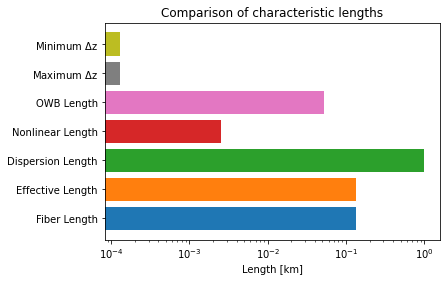

Running SSFM with nsteps = 1024
Finished running SSFM!!!


In [10]:
#https://prefetch.eu/know/concept/optical-wave-breaking/

#Run SSFM
ssfm_result_test = SSFM(fiber,testInputSignal,stepConfig=testStepConfig)



## Plot results

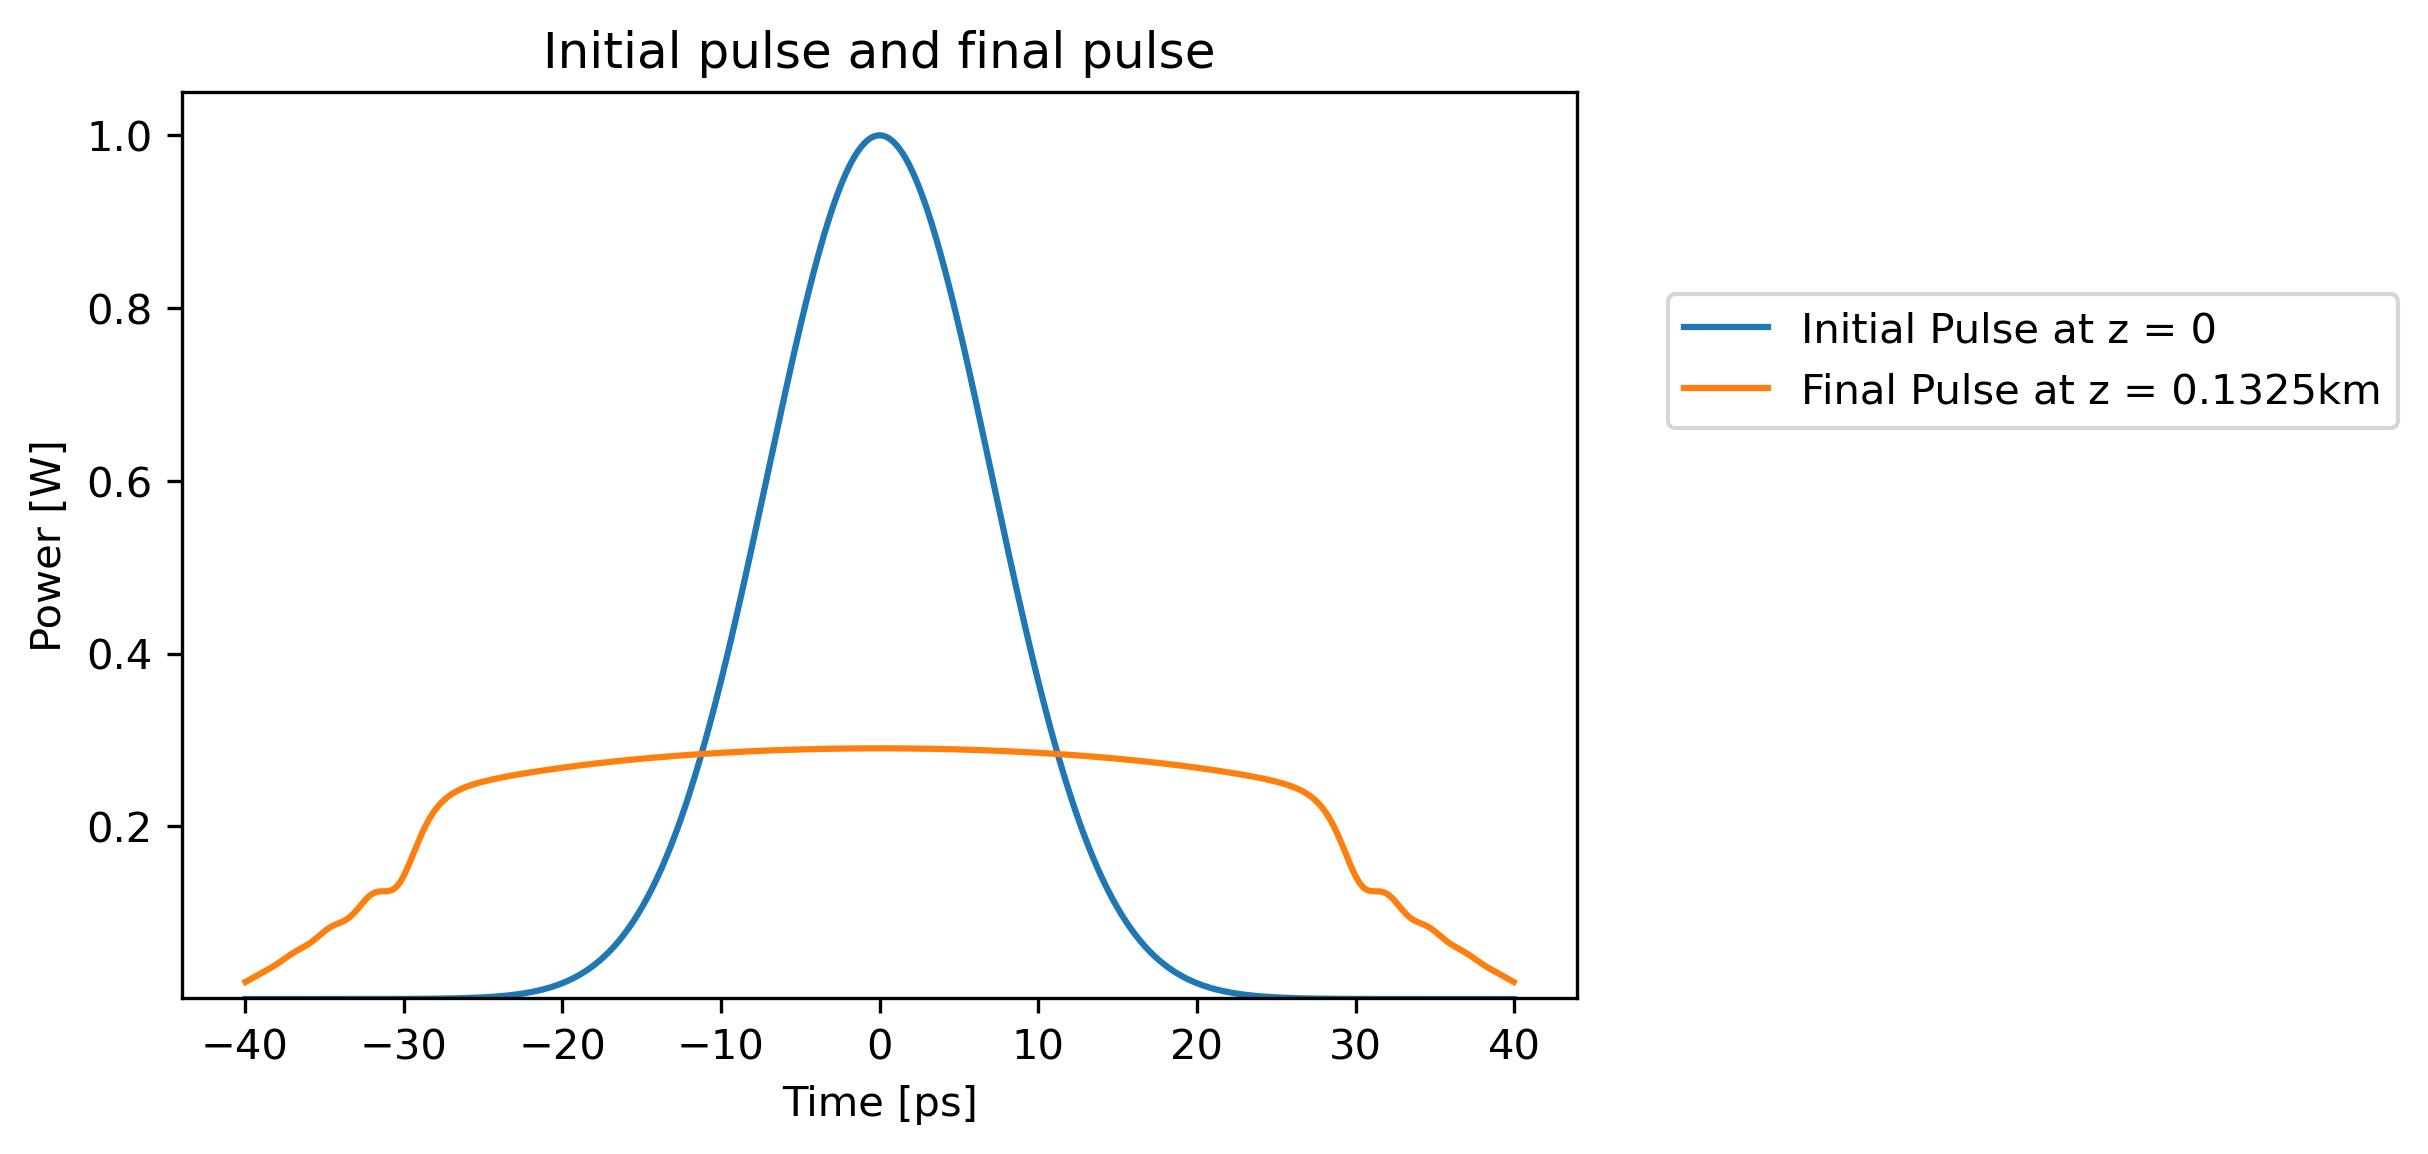

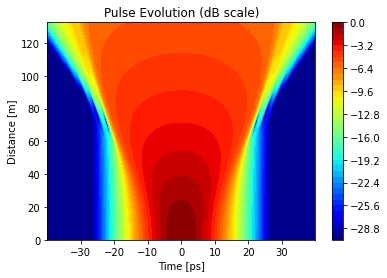

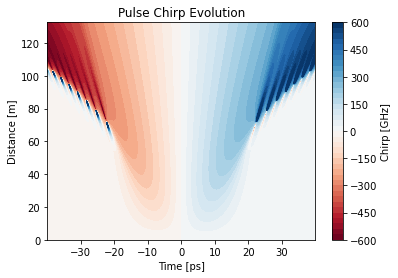

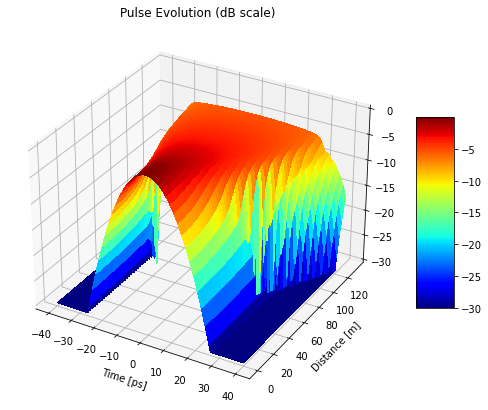

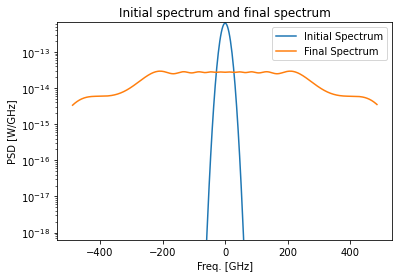

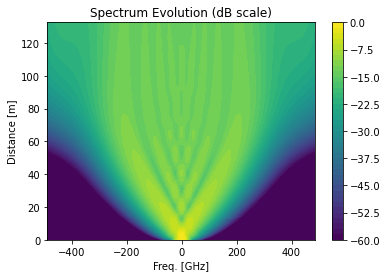

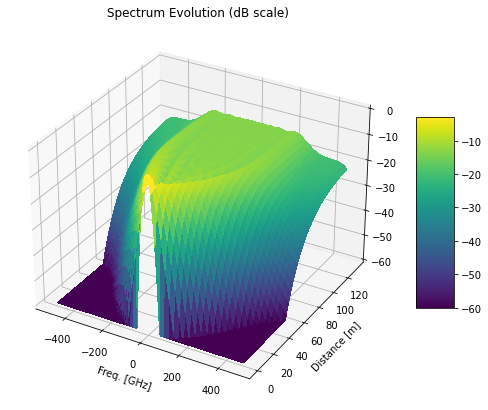

In [11]:
#Plot pulses
nrange_test=400
cutoff_test=-30
plotEverythingAboutPulses(ssfm_result_test,nrange_test,cutoff_test,chirpPlotRange=(-600,600))


#Plot spectra
nrange_test=200
cutoff_test=-60    
plotEverythingAboutSpectra(ssfm_result_test,nrange_test,cutoff_test)

In [ ]:
from matplotlib.animation import FuncAnimation, PillowWriter
from matplotlib.legend import LineCollection
from matplotlib.colors import ListedColormap, LinearSegmentedColormap

points = np.array( [ssfm_result_test.timeFreq.t*1e12 ,  getPower(ssfm_result_test.pulseMatrix[ssfm_result_test.n_z_steps,:])   ]  ).T.reshape(-1,1,2)
segments = np.concatenate([points[0:-1],points[1:]],axis=1)

#Make custom colormap
colors = ["red" ,"gray", "blue"]
cmap1 = LinearSegmentedColormap.from_list("mycmap", colors)

#Initialize color normalization function
norm = plt.Normalize(-600,600)

#Initialize line collection to be plotted
lc=LineCollection(segments,cmap=cmap1,norm=norm)
lc.set_array( getChirp(ssfm_result_test.timeFreq.t,ssfm_result_test.pulseMatrix[ssfm_result_test.n_z_steps,:])/1e9 )

#Initialize figure
fig, ax = plt.subplots(dpi=150)
line = ax.add_collection(lc)
fig.colorbar(line,ax=ax, label = 'Chirp [GHz]')


#Function for specifying axes
def init():
  

  ax.set_xlim([-testInputSignal.duration*3.5*1e12,testInputSignal.duration*3.5*1e12])
  ax.set_ylim([0,1.05*testInputSignal.Pmax])
  
  ax.set_xlabel('Time [ps]')
  ax.set_ylabel('Power [W]')
#Function for updating the plot in the .gif
def update(i):
  ax.clear() #Clear figure
  init()     #Reset axes
  ax.set_title(f'Optical Wave breaking, z={np.round(ssfm_result_test.zvals[i],1)}m ')
  #Make collection of points from pulse power
  points = np.array( [ssfm_result_test.timeFreq.t*1e12 ,  getPower(ssfm_result_test.pulseMatrix[i,:])   ]  ).T.reshape(-1,1,2)
  
  #Make collection of lines from points
  segments = np.concatenate([points[0:-1],points[1:]],axis=1)
  lc=LineCollection(segments,cmap=cmap1,norm=norm)

  #Activate norm function based on local chirp
  lc.set_array( getChirp(ssfm_result_test.timeFreq.t,ssfm_result_test.pulseMatrix[i,:])/1e9 )
  
  #Plot line
  line = ax.add_collection(lc)



#Make animation
ani = FuncAnimation(fig,update,range(ssfm_result_test.n_z_locs),init_func=init)
plt.show()

#Save animation as .gif
framerate=30 # Framerate of 30 will look smooth
writer = PillowWriter(fps=framerate)
ani.save(f'OWB_={framerate}.gif',writer=writer)